<a href="https://colab.research.google.com/github/Ofir408/cnn-flowers-classification/blob/main/flowers_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ofir Ben Shoham

## Setup

In [ ]:
import pandas as pd
import numpy as np
import scipy.io
import torchvision
from torchvision import datasets, models, transforms
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

BASE_PATH = "ex3/"
IMAGES_PATH = BASE_PATH + "jpg/"


## Load the Data

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

mat1 = scipy.io.loadmat('imagelabels.mat')

labels = mat1['labels'][0]
for folder_name in ["train", "validation", "test"]:
  os.makedirs(BASE_PATH + folder_name, exist_ok=True)


--2022-07-01 07:28:11--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502
Saving to: ‘imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2022-07-01 07:28:12 (76.0 MB/s) - ‘imagelabels.mat’ saved [502/502]

--2022-07-01 07:28:12--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  13.8MB/s    in 26s     

2022-07-01 07:28:39 (12.7 MB/s) - ‘102flowers.tgz’ saved [344862509/3

In [ ]:
!tar -xzf 102flowers.tgz -C "/content/ex3/"


In [ ]:
print(len(os.listdir(IMAGES_PATH)))
print(len(labels))
print(type(labels))

8189
8189
<class 'numpy.ndarray'>


In [ ]:
def get_img_tag(image_path):
  image_name = Path(image_path).stem.replace('image_', '')
  image_id = int(image_name)
  label = labels[image_id - 1]
  return label


### Split the data to train, test, validation folders

In [ ]:
from sklearn.model_selection import train_test_split

X_temp, X_test = train_test_split(os.listdir(IMAGES_PATH), test_size=0.25, stratify=labels)
X_train, X_validation = train_test_split(X_temp, test_size=0.33333333334) # todo: consider to add stratify if needed.
del X_temp

Y_test = [get_img_tag(img_path) for img_path in X_test]
Y_train = [get_img_tag(img_path) for img_path in X_train]
Y_validation = [get_img_tag(img_path) for img_path in X_validation]

In [ ]:
labels.min(), labels.max()

(1, 102)

In [ ]:
import shutil

def create_tag_folders(min_label, max_label):
  print('creating folders for each label...')
  for folder_type in ["train", "validation", "test"]:
    for label in range(min_label, max_label + 1):
      new_folder = f"{BASE_PATH}{folder_type}/{str(label)}"
      os.makedirs(new_folder, exist_ok=True)
  print('Done')

def write_tags_to_folders(images, labels, folder_type):
  print(f'start to copy images, folder_type={folder_type}')
  for image_name, label in zip(images, labels):
    current_image_path = f"{IMAGES_PATH}{image_name}"
    image_full_path = f"{BASE_PATH}{folder_type}/{str(label)}/{image_name}"
    #print(f"copy file from current={current_image_path}, new_path={image_full_path}")
    shutil.copyfile(src=current_image_path, dst=image_full_path)
  print('Done to write images to the folders of the tags')


In [ ]:
create_tag_folders(min_label=labels.min(), max_label=labels.max())
write_tags_to_folders(X_train, Y_train, folder_type="train")
write_tags_to_folders(X_validation, Y_validation, folder_type="validation")
write_tags_to_folders(X_test, Y_test, folder_type="test")

creating folders for each label...
Done
start to copy images, folder_type=train
Done to write images to the folders of the tags
start to copy images, folder_type=validation
Done to write images to the folders of the tags
start to copy images, folder_type=test
Done to write images to the folders of the tags


### Preprocessing

In [ ]:
transformations = transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
train_image_folder = torchvision.datasets.ImageFolder(f'{BASE_PATH}train', transform=transformations)
validation_image_folder = torchvision.datasets.ImageFolder(f'{BASE_PATH}validation', transform=transformations)
test_image_folder = torchvision.datasets.ImageFolder(f'{BASE_PATH}test', transform=transformations)


In [ ]:
print(f'size of train set is: {train_image_folder}')
print(f'size of validation set is: {validation_image_folder}')
print(f'size of test set is: {test_image_folder}')

size of train set is: Dataset ImageFolder
    Number of datapoints: 4093
    Root location: ex3/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
size of validation set is: Dataset ImageFolder
    Number of datapoints: 2048
    Root location: ex3/validation
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
size of test set is: Dataset ImageFolder
    Number of datapoints: 2048
    Root location: ex3/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_si

### Model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device={device}')

device=cuda:0


In [ ]:
# test_data_loader & validation_data_loader only for accuracy calculation, not for training of course. 

def train(model, train_data_loader, validation_data_loader, test_data_loader, criterion, optimizer, scheduler=None, num_epochs=10):
  epoch_to_acc_list = [] # list of tuples (train_accuracy, validation_accuracy, test_accuracy)
  epoch_to_loss_list = [] # list of tuples (train_loss, validation_loss, test_loss)
  for epoch in range(num_epochs):
      model.train()
      print(f'Epoch {epoch}/{num_epochs - 1}')
      total_loss, total_corrects = 0.0, 0
      for inputs, labels in train_data_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total_loss += loss.item() * inputs.size(0)
          total_corrects += torch.sum(preds == labels.data)
          
      #scheduler.step()
      epoch_accuracy = total_corrects.double().item() / len(train_data_loader.dataset)
      epoch_loss = total_loss / len(train_data_loader.dataset)
      validation_acc, validation_loss = calc_accuracy_and_loss(model, criterion, validation_data_loader)
      print(f'validation accuracy={validation_acc:.4f}')
      test_acc, test_loss = calc_accuracy_and_loss(model, criterion, test_data_loader)
      epoch_to_acc_list.append((epoch_accuracy, validation_acc, test_acc))
      epoch_to_loss_list.append((epoch_loss, validation_loss, test_loss))
      print(f'Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}, Epoch {epoch}/{num_epochs - 1}')
  return model, epoch_to_acc_list, epoch_to_loss_list

In [ ]:
def calc_accuracy_and_loss(model, criterion, data_loader):
  corrects = 0
  total_loss = 0.0
  model.eval()
  with torch.no_grad():
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)
        loss = criterion(outputs, labels)
        loss_val = loss.item() * inputs.size(0)
        total_loss += loss_val
        
  final_acc = corrects.double().item() / len(data_loader.dataset)
  final_loss = total_loss / len(data_loader.dataset)
  return final_acc, final_loss

In [ ]:
resnet_model = models.resnet152(pretrained=True)
model2 = models.convnext_large(pretrained=True)

#model2 = models.resnet50(pretrained=True)

#scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth


  0%|          | 0.00/755M [00:00<?, ?B/s]

In [ ]:
resnet_model

In [ ]:
model2

#### Fine Tuning to res-net

In [ ]:
for m in [resnet_model, model2]:
  print(f'freeze params of model={m.__class__.__name__}')
  for params in m.parameters():
    params.requires_grad = False
  _ = m.eval()

freeze params of model=ResNet
freeze params of model=ConvNeXt


In [ ]:
from collections import OrderedDict

resnet_model.fc = nn.Sequential(OrderedDict([
                      ('linear1', nn.Linear(resnet_model.fc.in_features, 256)),
                      ('relu_activation', nn.ReLU()),
                      ('linear2', nn.Linear(256, 102)),
                      ('last_layer', nn.LogSoftmax(dim=1))
                      ]))

del model2.classifier[-1]
model2.classifier.append(nn.Linear(1536, 256))
model2.classifier.append(nn.ReLU())
model2.classifier.append(nn.Linear(256, 102))
model2.classifier.append(nn.LogSoftmax(dim=1))

#model2.classifier.append(nn.ReLU())
#model2.classifier.append(nn.Linear(256, 102))
#model2.classifier.append(nn.LogSoftmax(dim=1))

Sequential(
  (0): LayerNorm2d((1536,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=1536, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=102, bias=True)
  (5): LogSoftmax(dim=1)
)

In [ ]:
trained_model, epoch_to_acc_list, epoch_to_loss_list = train(model= resnet_model.to(device), train_data_loader=DataLoader(train_image_folder, batch_size=64, shuffle=True),
                      validation_data_loader=DataLoader(validation_image_folder, batch_size=256, shuffle=False), # only for accuracy calculation, not for training of course. 
                      test_data_loader=DataLoader(test_image_folder, batch_size=256, shuffle=False), # only for accuracy calculation, not for training of course. 
                      criterion=nn.NLLLoss(), optimizer=optim.Adam(resnet_model.parameters(), lr = 0.001), num_epochs=9
)

Epoch 0/8
validation accuracy=0.6089
Loss: 3.4116 Acc: 0.3020, Epoch 0/8
Epoch 1/8
validation accuracy=0.7759
Loss: 1.4114 Acc: 0.7190, Epoch 1/8
Epoch 2/8
validation accuracy=0.8320
Loss: 0.7177 Acc: 0.8502, Epoch 2/8
Epoch 3/8
validation accuracy=0.8667
Loss: 0.4527 Acc: 0.9054, Epoch 3/8
Epoch 4/8
validation accuracy=0.8765
Loss: 0.3473 Acc: 0.9267, Epoch 4/8
Epoch 5/8
validation accuracy=0.8911
Loss: 0.2518 Acc: 0.9487, Epoch 5/8
Epoch 6/8
validation accuracy=0.9009
Loss: 0.2014 Acc: 0.9599, Epoch 6/8
Epoch 7/8
validation accuracy=0.8926
Loss: 0.1533 Acc: 0.9734, Epoch 7/8
Epoch 8/8
validation accuracy=0.9043
Loss: 0.1305 Acc: 0.9761, Epoch 8/8


In [ ]:
epoch_to_acc_list, epoch_to_loss_list


([(0.3019789885169802, 0.60888671875, 0.58349609375),
  (0.7190324945028097, 0.77587890625, 0.78076171875),
  (0.8502321035914977, 0.83203125, 0.83154296875),
  (0.9054483264109455, 0.86669921875, 0.86767578125),
  (0.926704129000733, 0.87646484375, 0.88134765625),
  (0.9486928903005131, 0.89111328125, 0.89453125),
  (0.9599315905204007, 0.90087890625, 0.90283203125),
  (0.9733691668702663, 0.892578125, 0.89794921875),
  (0.9760566821402394, 0.904296875, 0.90966796875)],
 [(3.4116247211142214, 2.080835744738579, 2.1090453565120697),
  (1.4113540969499596, 1.029984824359417, 1.0260654240846634),
  (0.7177301049523734, 0.7095211073756218, 0.6878028139472008),
  (0.45266504157239, 0.5602541826665401, 0.5509329177439213),
  (0.347252109014053, 0.47757613286376, 0.4686024896800518),
  (0.2517849047646207, 0.40592142939567566, 0.4027499370276928),
  (0.20143045735860143, 0.37438215501606464, 0.36293088644742966),
  (0.15334310858983036, 0.37056171149015427, 0.37412652373313904),
  (0.1305073

In [ ]:
print('training trasfer learning for 102-flowers classification')
trained_model2, epoch_to_acc_list2, epoch_to_loss_list2 = train(model= model2.to(device), train_data_loader=DataLoader(train_image_folder, batch_size=64, shuffle=True),
                      validation_data_loader=DataLoader(validation_image_folder, batch_size=256, shuffle=False), # only for accuracy calculation, not for training of course. 
                      test_data_loader=DataLoader(test_image_folder, batch_size=256, shuffle=False), # only for accuracy calculation, not for training of course. 
                      criterion=nn.NLLLoss(), optimizer=optim.Adam(model2.parameters(), lr = 0.001), num_epochs=9
)
print('Done')

training trasfer learning for 102-flowers classification
Epoch 0/8
validation accuracy=0.6157
Loss: 3.3503 Acc: 0.3157, Epoch 0/8
Epoch 1/8
validation accuracy=0.8145
Loss: 1.2981 Acc: 0.7405, Epoch 1/8
Epoch 2/8
validation accuracy=0.8765
Loss: 0.6709 Acc: 0.8607, Epoch 2/8
Epoch 3/8
validation accuracy=0.9189
Loss: 0.4275 Acc: 0.9196, Epoch 3/8
Epoch 4/8
validation accuracy=0.9243
Loss: 0.2937 Acc: 0.9458, Epoch 4/8
Epoch 5/8
validation accuracy=0.9375
Loss: 0.2186 Acc: 0.9594, Epoch 5/8
Epoch 6/8
validation accuracy=0.9438
Loss: 0.1753 Acc: 0.9677, Epoch 6/8
Epoch 7/8
validation accuracy=0.9487
Loss: 0.1359 Acc: 0.9809, Epoch 7/8
Epoch 8/8
validation accuracy=0.9463
Loss: 0.1052 Acc: 0.9853, Epoch 8/8
Done


### Accuracy graph and the Cross-Entropy graph 

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

def plot_epoch_accuracy_graph(epoch_to_measure_list, title, measure_name_label):
  epochs = [x + 1 for x in range(0, len(epoch_to_measure_list))]
  train_measure_list, val_measure_list, test_measure_list = [], [], []
  for x in epoch_to_measure_list:
      train_measure, val_measure, test_measure = x
      train_measure_list.append(train_measure)
      val_measure_list.append(val_measure)
      test_measure_list.append(test_measure)
  epoch_acc_df = pd.DataFrame({
      'epochs': epochs,
      'train': train_measure_list,
      'validation': val_measure_list,
      'test': test_measure_list
  })

  plt.figure(figsize=(10, 8))
  plt.title(title)
  plt.xlabel('epoch', fontsize=18)
  plt.ylabel(measure_name_label, fontsize=16)
  sns.lineplot(data=epoch_acc_df, x='epochs', y='train', color="red", label='train')
  sns.lineplot(data=epoch_acc_df, x='epochs', y='validation', color="blue", label='validation')
  sns.lineplot(data=epoch_acc_df, x='epochs', y='test', color="green", label='test')
  

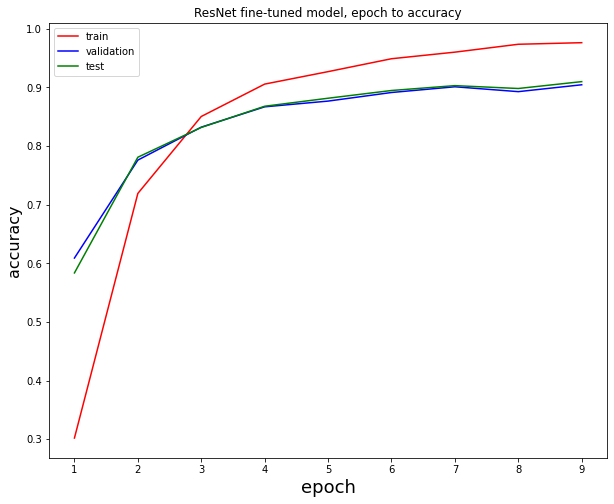

In [ ]:
plot_epoch_accuracy_graph(epoch_to_measure_list=epoch_to_acc_list, title='ResNet fine-tuned model, epoch to accuracy', measure_name_label='accuracy')

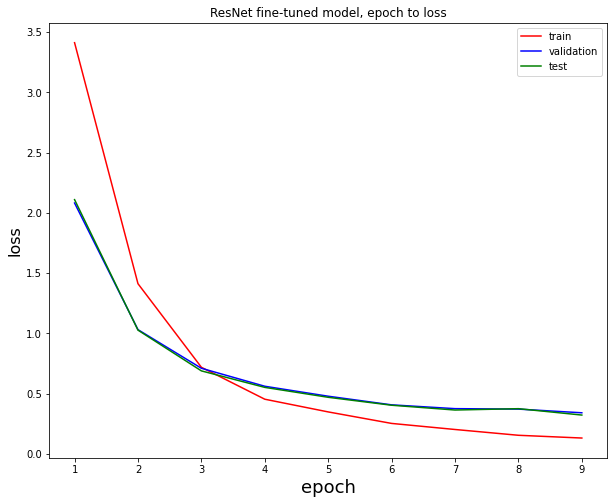

In [ ]:
plot_epoch_accuracy_graph(epoch_to_measure_list=epoch_to_loss_list, title='ResNet fine-tuned model, epoch to loss', measure_name_label='loss')

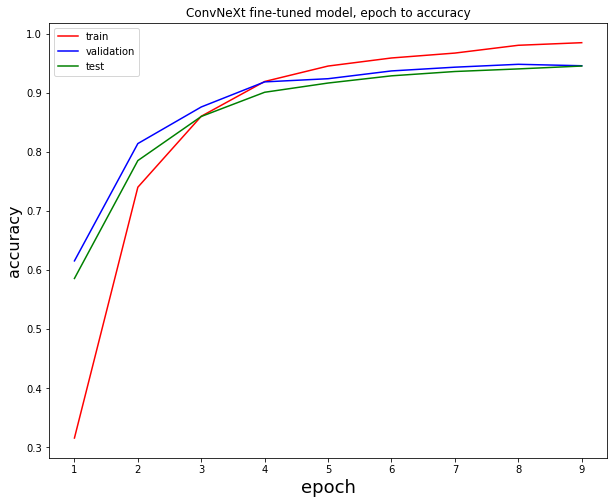

In [ ]:
plot_epoch_accuracy_graph(epoch_to_measure_list=epoch_to_acc_list2, title='ConvNeXt fine-tuned model, epoch to accuracy', measure_name_label='accuracy')

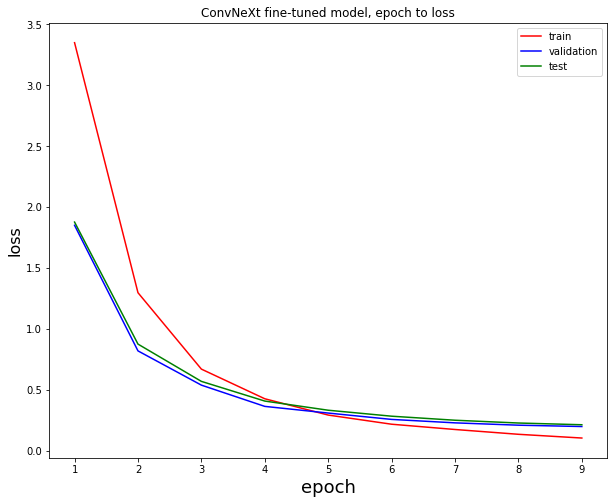

In [ ]:
plot_epoch_accuracy_graph(epoch_to_measure_list=epoch_to_loss_list2, title='ConvNeXt fine-tuned model, epoch to loss', measure_name_label='loss')